# Heist experiment

This notebook analyzes multi-agent negotiation experiments in the Heist scenario.

**Scenario:** Four heist crew members must divide the loot. Each has a distinct role and subjective perception of their contribution.

## Pdf image saving

In [64]:
import os
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent if (Path.cwd().name == "notebooks") else Path.cwd()
LOGS_DIR = PROJECT_ROOT / "logs"
FIGURES_DIR = PROJECT_ROOT / "figures"
os.makedirs(FIGURES_DIR, exist_ok=True)

def save_figure(fig, name: str, dpi: int = 300):
    fig.savefig(FIGURES_DIR / f"{name}.pdf", bbox_inches="tight", dpi=dpi)

In [65]:
COLOR_PALETTE = {
    'primary': 'steelblue',
    'secondary': 'purple',
    'success': 'green',
    'warning': 'orange',
    'danger': 'red',
    
        'agents': {
            'Viktor': 'steelblue',     
            'Marco': 'red',      
            'Elena': 'orange',   
            'Yuki': 'green'     
        }, 
    'agreement': 'green',
    'disagreement': 'red',
    'neutral': 'gray',
    'baseline': 'lightgray',
    'heatmap_seq': 'YlOrRd',
    'heatmap_div': 'RdYlGn',
    'gradient': 'viridis'
}

def get_agent_colors(agents=None):
    """Get ordered list of agent colors"""
    if agents is None:
        agents = ['Viktor', 'Marco', 'Elena', 'Yuki']
    return [COLOR_PALETTE['agents'][a] for a in agents]

def get_outcome_colors():
    """Get colors for agreement outcomes [Failed, Succeeded]"""
    return [COLOR_PALETTE['disagreement'], COLOR_PALETTE['agreement']]

In [66]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Any
import json
import math
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [67]:
def read_json(path: Path) -> dict[str, Any]:
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)


@dataclass(frozen=True)
class Experiment:
    path: Path
    name: str
    prefix: str
    stamp: str
    config: dict[str, Any]


def list_experiments(logs_dir: Path, prefix_startswith: str = "heist_") -> list[Experiment]:
    experiments = []
    for folder in sorted(logs_dir.iterdir()):
        if not folder.is_dir() or not folder.name.startswith(prefix_startswith):
            continue
        config_path = folder / "config.json"
        config = read_json(config_path) if config_path.exists() else {}
        parts = folder.name.split("_")
        if len(parts) >= 3:
            prefix = "_".join(parts[:-2]) 
            stamp = "_".join(parts[-2:])  
        else:
            prefix = folder.name
            stamp = ""
        experiments.append(Experiment(
            path=folder,
            name=folder.name,
            prefix=prefix,
            stamp=stamp,
            config=config
        ))
    return experiments


def newest_by_prefix(experiments: list[Experiment]) -> list[Experiment]:
    by_prefix: dict[str, Experiment] = {}
    for e in sorted(experiments, key=lambda x: x.stamp):
        by_prefix[e.prefix] = e
    return list(by_prefix.values())


def iter_run_files(exp_dir: Path) -> list[Path]:
    return sorted(exp_dir.glob("run_*.json"))

heist_experiments = list_experiments(LOGS_DIR, prefix_startswith="heist_")
heist_unique = newest_by_prefix(heist_experiments)

pd.DataFrame([{"prefix": e.prefix, "stamp": e.stamp, "path": str(e.path)} for e in heist_unique])

,prefix,stamp,path
0,heist_baseline,20260115_002211,/home/ygour/negotiation-arena/logs/heist_basel...
1,heist_no_threats,20260115_003124,/home/ygour/negotiation-arena/logs/heist_no_th...
2,heist_no_coalitions,20260115_004025,/home/ygour/negotiation-arena/logs/heist_no_co...
3,heist_minimal,20260115_004945,/home/ygour/negotiation-arena/logs/heist_minim...
4,heist_high_greed,20260115_005741,/home/ygour/negotiation-arena/logs/heist_high_...


### Data Loading

In [68]:
def compute_gini(shares: list[float]) -> float:
    if not shares or sum(shares) == 0:
        return 0.0
    n = len(shares)
    shares_sorted = sorted(shares)
    cumsum = 0
    gini_sum = 0
    for s in shares_sorted:
        cumsum += s
        gini_sum += cumsum
    return (n + 1 - 2 * gini_sum / cumsum) / n if cumsum > 0 else 0


def load_heist_runs(experiments: list[Experiment]) -> pd.DataFrame:
    rows = []
    
    for exp in experiments:
        condition = exp.config.get("condition", exp.prefix.replace("heist_", ""))
        
        for run_path in iter_run_files(exp.path):
            run = read_json(run_path)
            
            if "deal_reached" in run:
                agreed = run.get("deal_reached", False)
                reason = run.get("termination_reason", "unknown")
                allocation = run.get("final_allocation", {})
                rounds = run.get("total_rounds", 0)
                turns = run.get("total_turns", 0)
                gini = run.get("gini_coefficient", 0)
                proposals_by_agent = run.get("proposals_by_agent", {})
                threats_by_agent = run.get("threats_by_agent", {})
            else:
                outcome = run.get("outcome", {})
                agreed = outcome.get("agreed", False)
                reason = outcome.get("reason", "unknown")
                allocation = outcome.get("final_proposal", {})
                turns_list = run.get("turns", [])
                rounds = max([t.get("round", 0) for t in turns_list], default=0)
                turns = len(turns_list)
                gini = compute_gini(list(allocation.values())) if allocation else 0
                proposals_by_agent = {}
                threats_by_agent = {}
            
            row = {
                "experiment": exp.name,
                "condition": condition,
                "run_id": run_path.stem,
                "agreed": agreed,
                "collapsed": "withdrawal" in reason.lower() or "collapse" in reason.lower(),
                "reason": reason,
                "rounds": rounds,
                "turns": turns,
                "gini": gini if agreed else np.nan,
            }
            
            for agent in ["Viktor", "Marco", "Elena", "Yuki"]:
                row[f"share_{agent}"] = allocation.get(agent, np.nan) if agreed else np.nan
                row[f"proposals_{agent}"] = proposals_by_agent.get(agent, 0)
                row[f"threats_{agent}"] = threats_by_agent.get(agent, 0)
            
            rows.append(row)
    
    return pd.DataFrame(rows)


heist_runs = load_heist_runs(heist_unique)
print(f"Loaded {len(heist_runs)} runs")
heist_runs.head()

Loaded 250 runs


,experiment,condition,run_id,agreed,collapsed,reason,rounds,turns,gini,share_Viktor,...,threats_Viktor,share_Marco,proposals_Marco,threats_Marco,share_Elena,proposals_Elena,threats_Elena,share_Yuki,proposals_Yuki,threats_Yuki
0,heist_baseline_20260115_002211,baseline,run_001,True,False,unanimous agreement,5,17,0.100000,28.0,...,1,32.0,4,0,NaN,1,1,20.0,2,1
1,heist_baseline_20260115_002211,baseline,run_002,True,False,unanimous agreement,3,9,0.157500,28.0,...,1,35.0,2,2,20.5,0,2,16.5,1,0
2,heist_baseline_20260115_002211,baseline,run_003,True,False,unanimous agreement,4,14,0.188596,30.0,...,0,42.0,3,0,28.0,2,0,14.0,1,0
3,heist_baseline_20260115_002211,baseline,run_004,True,False,unanimous agreement,3,11,0.140000,30.0,...,0,32.0,1,0,22.0,0,0,16.0,2,0
4,heist_baseline_20260115_002211,baseline,run_005,True,False,unanimous agreement,4,15,0.135000,22.0,...,0,34.0,2,0,26.5,1,1,17.5,2,0


In [69]:
display(heist_runs.groupby("condition").agg({
    "run_id": "count",
    "agreed": "mean",
    "collapsed": "mean",
    "rounds": "mean"
}).rename(columns={"run_id": "n_runs", "agreed": "agreement_rate", "collapsed": "collapse_rate"}).round(2))

,n_runs,agreement_rate,collapse_rate,rounds
condition,,,,
baseline,50,0.92,0.08,2.90
high_greed,50,0.66,0.34,3.12
minimal,50,0.94,0.06,2.88
no_coalitions,50,0.94,0.06,2.90
no_threats,50,0.94,0.06,2.88


### Experimental Conditions

| Condition | Description |
|-----------|-------------|
| `baseline` | Full negotiation capabilities (threats + coalitions) |
| `no_threats` | Agents cannot make withdrawal threats |
| `no_coalitions` | Agents cannot form alliances |
| `high_greed` | Agents have elevated self-interest parameters |
| `minimal` | Minimal system prompt |

## Agreement and Collapse rates

In [70]:
def wilson_ci(k: int, n: int, z: float = 1.96) -> tuple[float, float]:
    """Wilson score interval"""
    if n == 0:
        return (np.nan, np.nan)
    phat = k / n
    denom = 1 + (z**2) / n
    center = (phat + (z**2) / (2*n)) / denom
    half = (z / denom) * math.sqrt((phat*(1-phat) / n) + (z**2) / (4*n*n))
    return (max(0.0, center - half), min(1.0, center + half))


def summarize_heist(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for cond, grp in df.groupby("condition"):
        n = len(grp)
        agreed = grp["agreed"].sum()
        collapsed = grp["collapsed"].sum()
        
        ag_lo, ag_hi = wilson_ci(agreed, n)
        deals = grp[grp["agreed"]]
        
        rows.append({
            "condition": cond,
            "n_runs": n,
            "agreement_rate": agreed / n,
            "agreement_ci_low": ag_lo,
            "agreement_ci_high": ag_hi,
            "collapse_rate": collapsed / n,
            "avg_rounds": grp["rounds"].mean(),
            "avg_gini": deals["gini"].mean() if len(deals) > 0 else np.nan,
            "avg_share_Viktor": deals["share_Viktor"].mean() if len(deals) > 0 else np.nan,
            "avg_share_Marco": deals["share_Marco"].mean() if len(deals) > 0 else np.nan,
            "avg_share_Elena": deals["share_Elena"].mean() if len(deals) > 0 else np.nan,
            "avg_share_Yuki": deals["share_Yuki"].mean() if len(deals) > 0 else np.nan,
        })
    
    return pd.DataFrame(rows)


heist_summary = summarize_heist(heist_runs)
display(heist_summary)

,condition,n_runs,agreement_rate,agreement_ci_low,agreement_ci_high,collapse_rate,avg_rounds,avg_gini,avg_share_Viktor,avg_share_Marco,avg_share_Elena,avg_share_Yuki
0,baseline,50,0.92,0.811615,0.968451,0.08,2.90,0.147849,27.619565,33.782609,21.393333,17.550000
1,high_greed,50,0.66,0.521536,0.775632,0.34,3.12,0.148636,27.651515,33.531250,21.333333,18.500000
2,minimal,50,0.94,0.837827,0.979385,0.06,2.88,0.153078,28.744681,33.329787,20.902174,17.478261
3,no_coalitions,50,0.94,0.837827,0.979385,0.06,2.90,0.141639,27.968085,32.606383,22.117021,17.478723
4,no_threats,50,0.94,0.837827,0.979385,0.06,2.88,0.129653,27.457447,32.314894,21.361702,18.887234


In [71]:
def to_latex_table(df: pd.DataFrame, caption: str, label: str) -> str:
    latex = df.to_latex(
        index=False,
        float_format="%.3f",
        caption=caption,
        label=label,
        position="htbp"
    )
    return latex

if len(heist_summary) > 0:
    paper_table = heist_summary[[
        "condition", "n_runs", "agreement_rate", "collapse_rate", "avg_gini", "avg_rounds"
    ]].copy()
    paper_table.columns = ["Condition", "N", "Agreement Rate", "Collapse Rate", "Mean Gini", "Mean Rounds"]
    paper_table = paper_table.round(3)
    
    display(paper_table)
    print(to_latex_table(paper_table, "Summary statistics for Heist negotiation experiments", "tab:heist_summary"))
    print("\n")

,Condition,N,Agreement Rate,Collapse Rate,Mean Gini,Mean Rounds
0,baseline,50,0.92,0.08,0.148,2.90
1,high_greed,50,0.66,0.34,0.149,3.12
2,minimal,50,0.94,0.06,0.153,2.88
3,no_coalitions,50,0.94,0.06,0.142,2.90
4,no_threats,50,0.94,0.06,0.130,2.88


\begin{table}[htbp]
\caption{Summary statistics for Heist negotiation experiments}
\label{tab:heist_summary}
\begin{tabular}{lrrrrr}
\toprule
Condition & N & Agreement Rate & Collapse Rate & Mean Gini & Mean Rounds \\
\midrule
baseline & 50 & 0.920 & 0.080 & 0.148 & 2.900 \\
high_greed & 50 & 0.660 & 0.340 & 0.149 & 3.120 \\
minimal & 50 & 0.940 & 0.060 & 0.153 & 2.880 \\
no_coalitions & 50 & 0.940 & 0.060 & 0.142 & 2.900 \\
no_threats & 50 & 0.940 & 0.060 & 0.130 & 2.880 \\
\bottomrule
\end{tabular}
\end{table}





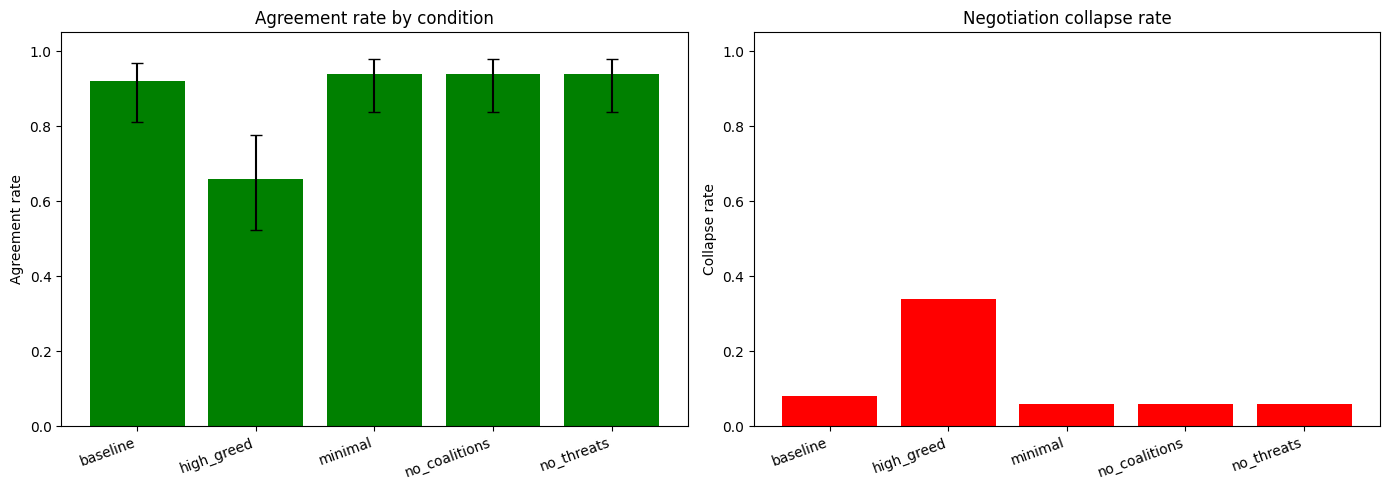

In [72]:
if len(heist_summary) > 0:
    cond_order = heist_summary["condition"].tolist()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    x = np.arange(len(heist_summary))
    axes[0].bar(x, heist_summary["agreement_rate"], color=COLOR_PALETTE['agreement'])
    axes[0].errorbar(
        x, heist_summary["agreement_rate"],
        yerr=[
            heist_summary["agreement_rate"] - heist_summary["agreement_ci_low"],
            heist_summary["agreement_ci_high"] - heist_summary["agreement_rate"]
        ],
        fmt="none", ecolor="black", capsize=4
    )
    axes[0].set_ylim(0, 1.05)
    axes[0].set_ylabel("Agreement rate")
    axes[0].set_title("Agreement rate by condition")
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(cond_order, rotation=20, ha="right")
    
    axes[1].bar(x, heist_summary["collapse_rate"], color=COLOR_PALETTE['disagreement'])
    axes[1].set_ylim(0, 1.05)
    axes[1].set_ylabel("Collapse rate")
    axes[1].set_title("Negotiation collapse rate")
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(cond_order, rotation=20, ha="right")
    
    plt.tight_layout()
    plt.show()
    save_figure(fig, "heist_agreement_collapse_rates")

## Fairness Analysis

Gini coefficient (0 = perfect equality) and share distributions by role. Obviously only if a deal is reached.

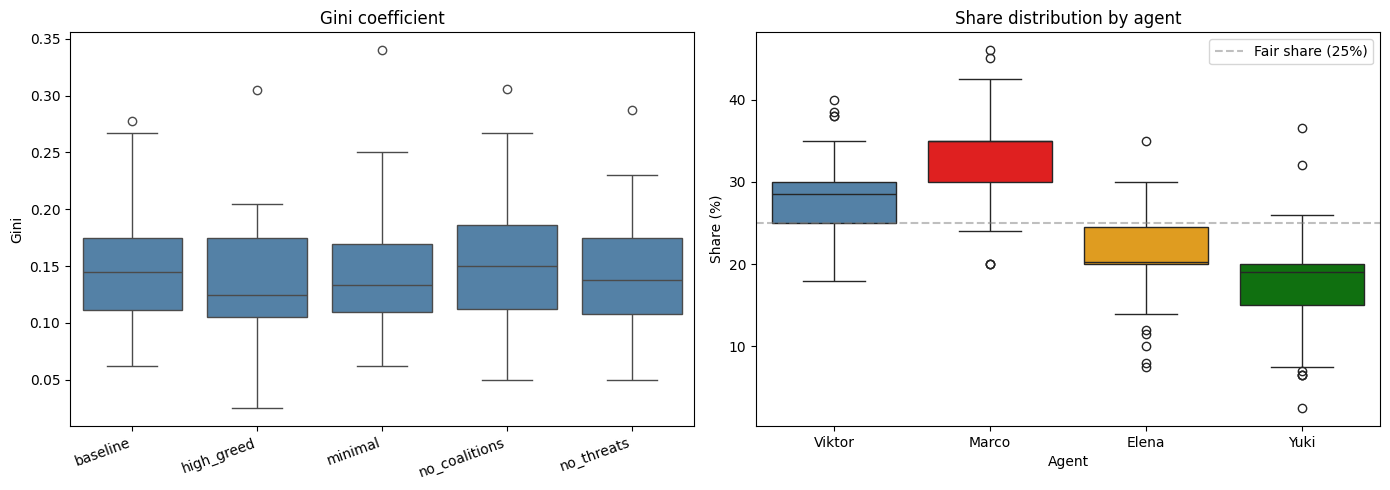

In [73]:
deals = heist_runs[heist_runs["agreed"]].copy()

if len(deals) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    sns.boxplot(data=deals, x="condition", y="gini", ax=axes[0], color=COLOR_PALETTE['primary'])
    axes[0].set_title("Gini coefficient")
    axes[0].set_ylabel("Gini")
    axes[0].set_xticks(x)
    axes[0].set_xlabel("")
    axes[0].set_xticklabels(cond_order, rotation=20, ha="right")
    
    share_cols = [c for c in deals.columns if c.startswith("share_")]
    share_data = deals[share_cols].melt(var_name="agent", value_name="share")
    share_data["agent"] = share_data["agent"].str.replace("share_", "")
    
    agent_order = ["Viktor", "Marco", "Elena", "Yuki"]
    agent_colors = get_agent_colors(agent_order)
    
    sns.boxplot(data=share_data, x="agent", y="share", ax=axes[1], 
                order=agent_order, palette=agent_colors)
    axes[1].axhline(y=25, color=COLOR_PALETTE['neutral'], linestyle="--", alpha=0.5, label="Fair share (25%)")
    axes[1].set_title("Share distribution by agent")
    axes[1].set_ylabel("Share (%)")
    axes[1].set_xlabel("Agent")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    save_figure(fig, "heist_gini_and_shares_analysis")

In [74]:
if len(deals) > 0:
    fair_share = 25.0
    
    results_rows = []
    for agent in ["Viktor", "Marco", "Elena", "Yuki"]:
        col = f"share_{agent}"
        shares = deals[col].dropna()
        if len(shares) > 0:
            mean = shares.mean()
            std = shares.std()
            t_stat, p_value = stats.ttest_1samp(shares, fair_share)
            cohens_d = (mean - fair_share) / std if std > 0 else 0
            sig = "***" if p_value < 0.001 else ("**" if p_value < 0.01 else ("*" if p_value < 0.05 else ""))
            
            results_rows.append({
                "Agent": agent,
                "Mean Share (%)": round(mean, 1),
                "SD": round(std, 1),
                "Δ (from 25%)": round(mean - fair_share, 1),
                "t": round(t_stat, 2),
                "p-value": round(p_value, 4),
                "Cohen d": round(cohens_d, 2),
            })
    
    if results_rows:
        fairness_df = pd.DataFrame(results_rows)
        display(fairness_df)
        print(to_latex_table(fairness_df, "Deviation from fair share (25\\%) by agent", "tab:heist_fairness"))

,Agent,Mean Share (%),SD,Δ (from 25%),t,p-value,Cohen d
0,Viktor,27.9,3.9,2.9,11.01,0.0,0.74
1,Marco,33.1,3.9,8.1,30.35,0.0,2.05
2,Elena,21.4,4.0,-3.6,-13.21,0.0,-0.89
3,Yuki,17.9,4.6,-7.1,-22.46,0.0,-1.52


\begin{table}[htbp]
\caption{Deviation from fair share (25\%) by agent}
\label{tab:heist_fairness}
\begin{tabular}{lrrrrrr}
\toprule
Agent & Mean Share (%) & SD & Δ (from 25%) & t & p-value & Cohen d \\
\midrule
Viktor & 27.900 & 3.900 & 2.900 & 11.010 & 0.000 & 0.740 \\
Marco & 33.100 & 3.900 & 8.100 & 30.350 & 0.000 & 2.050 \\
Elena & 21.400 & 4.000 & -3.600 & -13.210 & 0.000 & -0.890 \\
Yuki & 17.900 & 4.600 & -7.100 & -22.460 & 0.000 & -1.520 \\
\bottomrule
\end{tabular}
\end{table}



## Negotiation Dynamics

Proposals and threats by agent.

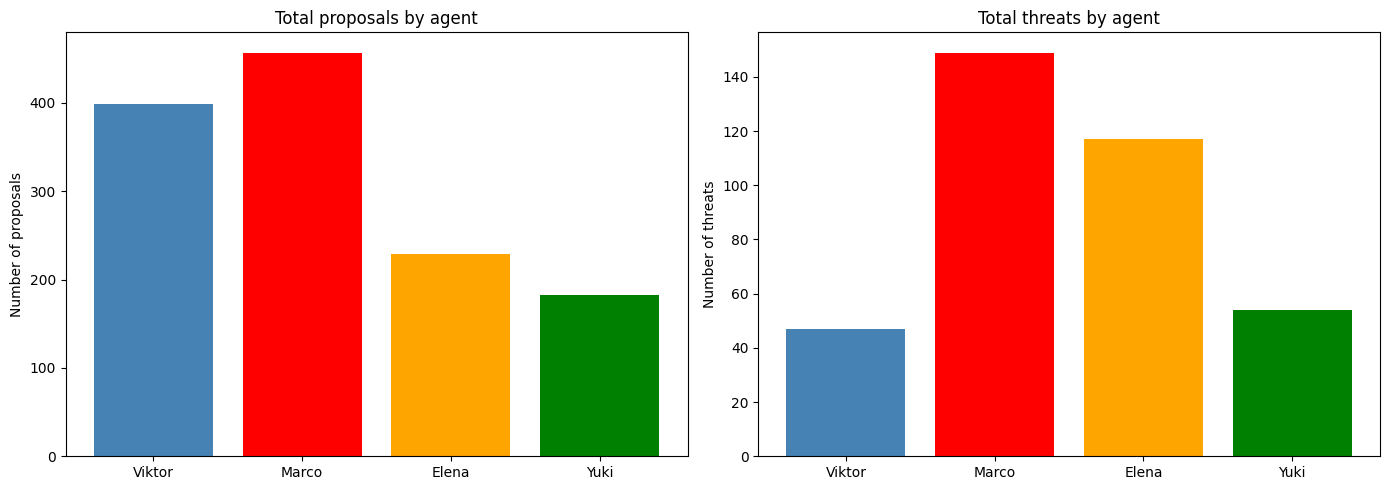

In [75]:
proposal_cols = [c for c in heist_runs.columns if c.startswith("proposals_")]
threat_cols = [c for c in heist_runs.columns if c.startswith("threats_")]

if proposal_cols:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    proposal_totals = heist_runs[proposal_cols].sum()
    proposal_totals.index = [c.replace("proposals_", "") for c in proposal_totals.index]
    agent_colors = get_agent_colors(list(proposal_totals.index))
    axes[0].bar(proposal_totals.index, proposal_totals.values, color=agent_colors)
    axes[0].set_title("Total proposals by agent")
    axes[0].set_ylabel("Number of proposals")
    axes[0].set_xticklabels(proposal_totals.index, rotation=0, ha="center")
    
    if threat_cols:
        threat_totals = heist_runs[threat_cols].sum()
        threat_totals.index = [c.replace("threats_", "") for c in threat_totals.index]
        agent_colors = get_agent_colors(list(threat_totals.index))
        axes[1].bar(threat_totals.index, threat_totals.values, color=agent_colors)
        axes[1].set_title("Total threats by agent")
        axes[1].set_ylabel("Number of threats")
        axes[1].set_xticklabels(threat_totals.index, rotation=0, ha="center")

    plt.tight_layout()

    plt.show()    
    save_figure(fig, "heist_proposals_and_threats_analysis")

In [76]:
if len(deals) > 0 and threat_cols:
    print("CORRELATION: Threats -> Share (do threats pay off?)")
    
    for agent in ["Viktor", "Marco", "Elena", "Yuki"]:
        threat_col = f"threats_{agent}"
        share_col = f"share_{agent}"
        
        if threat_col in deals.columns and share_col in deals.columns:
            valid = deals[[threat_col, share_col]].dropna()
            if len(valid) > 3:
                corr, p = stats.pearsonr(valid[threat_col], valid[share_col])
                sig = "*" if p < 0.05 else ""
                print(f"{agent}: r = {corr:+.3f}, p = {p:.4f} {sig}")

CORRELATION: Threats -> Share (do threats pay off?)
Viktor: r = +0.123, p = 0.0688 
Marco: r = +0.023, p = 0.7305 
Elena: r = +0.242, p = 0.0003 *
Yuki: r = -0.139, p = 0.0399 *


### Statistical Tests

Agreement rate differences

In [77]:
from itertools import combinations

conditions = heist_runs["condition"].unique()

if len(conditions) >= 2:
    chi_rows = []
    
    for c1, c2 in combinations(conditions, 2):
        g1 = heist_runs[heist_runs["condition"] == c1]["agreed"]
        g2 = heist_runs[heist_runs["condition"] == c2]["agreed"]
        
        contingency = [
            [g1.sum(), len(g1) - g1.sum()],
            [g2.sum(), len(g2) - g2.sum()]
        ]
        chi2, p, dof, expected = stats.chi2_contingency(contingency)
        sig = "***" if p < 0.001 else ("**" if p < 0.01 else ("*" if p < 0.05 else ""))
        
        chi_rows.append({
            "Comparison": f"{c1} vs {c2}",
            "Agreement 1": f"{g1.mean():.1%}",
            "Agreement 2": f"{g2.mean():.1%}",
            "Chi-Square": round(chi2, 3),
            "p-value": round(p, 4),
        })
    
    chi_df = pd.DataFrame(chi_rows)
    display(chi_df)

,Comparison,Agreement 1,Agreement 2,Chi-Square,p-value
0,baseline vs no_threats,92.0%,94.0%,0.000,1.0000
1,baseline vs no_coalitions,92.0%,94.0%,0.000,1.0000
2,baseline vs minimal,92.0%,94.0%,0.000,1.0000
3,baseline vs high_greed,92.0%,66.0%,8.680,0.0032
4,no_threats vs no_coalitions,94.0%,94.0%,0.000,1.0000
5,no_threats vs minimal,94.0%,94.0%,0.000,1.0000
6,no_threats vs high_greed,94.0%,66.0%,10.562,0.0012
7,no_coalitions vs minimal,94.0%,94.0%,0.000,1.0000
8,no_coalitions vs high_greed,94.0%,66.0%,10.562,0.0012
9,minimal vs high_greed,94.0%,66.0%,10.562,0.0012


Baseline vs High Greed Chi-Square Test

In [ ]:
baseline_data = heist_runs[heist_runs["condition"] == "baseline"]
high_greed_data = heist_runs[heist_runs["condition"] == "high_greed"]

if len(baseline_data) > 0 and len(high_greed_data) > 0:
    baseline_success = baseline_data["agreed"].sum()
    baseline_failure = len(baseline_data) - baseline_success
    
    high_greed_success = high_greed_data["agreed"].sum()
    high_greed_failure = len(high_greed_data) - high_greed_success
    
    contingency_table = np.array([
        [baseline_success, baseline_failure],
        [high_greed_success, high_greed_failure]
    ])
    
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    contingency_df = pd.DataFrame({
        "Condition": ["Baseline", "High Greed"],
        "Success": [baseline_success, high_greed_success],
        "Failure": [baseline_failure, high_greed_failure],
        "Total": [len(baseline_data), len(high_greed_data)],
        "Success Rate (%)": [
            baseline_success/len(baseline_data)*100,
            high_greed_success/len(high_greed_data)*100
        ]
    })
    
    display(contingency_df)
    
    test_results_df = pd.DataFrame({
        "Statistic": ["Chi-Square", "P-value"],
        "Value": [chi2, p_value]
    })
    
    display(test_results_df)

,Condition,Success,Failure,Total,Success Rate (%)
0,Baseline,46,4,50,92.0
1,High Greed,33,17,50,66.0


,Statistic,Value
0,Chi-Square,8.679928
1,P-value,0.003217


## NLP Analysis

This section applies core NLP techniques to analyze the negotiation dialogues

In [79]:
def load_turns_df(experiments: list[Experiment]) -> pd.DataFrame:
    rows = []
    
    for exp in experiments:
        condition = exp.config.get("condition", exp.prefix.replace("heist_", ""))
        
        for run_path in iter_run_files(exp.path):
            run = read_json(run_path)
            run_id = run_path.stem
            
            if "deal_reached" in run:
                agreed = run.get("deal_reached", False)
            else:
                outcome = run.get("outcome", {})
                agreed = outcome.get("agreed", False)
            
            turns = run.get("turns", [])
            for turn in turns:
                rows.append({
                    "experiment": exp.name,
                    "condition": condition,
                    "run_id": run_id,
                    "agreed": agreed,
                    "round": turn.get("round_num", 0),
                    "turn_in_round": turn.get("turn_in_round", 0),
                    "agent": turn.get("agent_name", ""),
                    "role": turn.get("role", ""),
                    "content": turn.get("response", ""),
                    "made_proposal": turn.get("made_proposal", False),
                    "made_threat": turn.get("made_threat", False),
                    "accepted": turn.get("accepted", False),
                    "withdrew": turn.get("withdrew", False),
                })
    
    return pd.DataFrame(rows)


turns_df = load_turns_df(heist_unique)
turns_df.head()

,experiment,condition,run_id,agreed,round,turn_in_round,agent,role,content,made_proposal,made_threat,accepted,withdrew
0,heist_baseline_20260115_002211,baseline,run_001,True,1,1,Viktor,mastermind,"PROPOSAL: Viktor: 30.0%, Marco: 20.0%, Elena: ...",True,False,False,False
1,heist_baseline_20260115_002211,baseline,run_001,True,1,2,Marco,executor,"[PROPOSAL]: Marco: 35.0%, Viktor: 25.0%, Elena...",True,False,False,False
2,heist_baseline_20260115_002211,baseline,run_001,True,1,3,Elena,financier,[ACCEPT],False,False,True,False
3,heist_baseline_20260115_002211,baseline,run_001,True,1,4,Yuki,support,"[PROPOSAL]: Viktor: 25.0%, Marco: 30.0%, Elena...",True,False,False,False
4,heist_baseline_20260115_002211,baseline,run_001,True,2,1,Viktor,mastermind,"[PROPOSAL]: Viktor: 28.0%, Marco: 30.0%, Elena...",False,False,True,False


In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from sentence_transformers import SentenceTransformer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('ignore')

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
sentiment_analyzer = SentimentIntensityAnalyzer()

### TF-IDF

TF-IDF (Term Frequency - Inverse Document Frequency) identifies words that are **distinctively important** for each agent.
- **TF**: How often a word appears in an agent's messages
- **IDF**: How rare the word is across all agents (penalizes common words like "the", "share")

In [81]:
CUSTOM_STOP_WORDS = {
    "viktor", "marco", "elena", "yuki",
    "mastermind", "executor", "financier", "support",
    "proposal", 
    "share", "shares", "percent", "percentage",
    "allocation", "allocate", "allocated",
    "agree", "agreed", "agreement", "disagree",
    "accept", "accepted", "reject", "rejected",
    "offer", "offers", "offered", "counter", "counteroffer",
    "think", "believe", "suggest", "feel", "want", "need",
    "would", "could", "should", "will", "let", "get", "got",
    "say", "said", "know", "make", "take", "give", "gave",
}

def extract_tfidf_signatures(df: pd.DataFrame, top_n: int = 15, 
                              custom_stops: set = CUSTOM_STOP_WORDS) -> dict[str, pd.DataFrame]:
    agents = df["agent"].unique()
    agent_texts = {agent: " ".join(df[df["agent"] == agent]["content"].dropna().tolist()) 
                   for agent in agents if agent}
    
    if not agent_texts:
        return {}
    
    from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
    all_stop_words = ENGLISH_STOP_WORDS.union(custom_stops)
    
    vectorizer = TfidfVectorizer(
        stop_words=list(all_stop_words),
        ngram_range=(1, 2), # unigrams and bigrams
        max_features=500,
        min_df=2, # appear in at least 2 documents
        lowercase=True,
        token_pattern=r'\b[a-zA-Z]{3,}\b' # words with 3+ letters
    )
    
    corpus = list(agent_texts.values())
    agent_names = list(agent_texts.keys())
    
    try:
        tfidf_matrix = vectorizer.fit_transform(corpus)
        feature_names = vectorizer.get_feature_names_out()
    except ValueError as e:
        print(f"TF-IDF error: {e}")
        return {}
    
    signatures = {}
    name_patterns = {"viktor", "marco", "elena", "yuki"}
    
    for idx, agent in enumerate(agent_names):
        scores = tfidf_matrix[idx].toarray().flatten()
        sorted_indices = scores.argsort()[::-1]
        
        filtered_terms = []
        for i in sorted_indices:
            term = feature_names[i]
            if not any(name in term.lower() for name in name_patterns):
                filtered_terms.append((term, scores[i]))
            if len(filtered_terms) >= top_n:
                break
        
        signatures[agent] = pd.DataFrame({
            "term": [t[0] for t in filtered_terms],
            "tfidf_score": [t[1] for t in filtered_terms]
        })
    
    return signatures


if len(turns_df) > 0:
    tfidf_signatures = extract_tfidf_signatures(turns_df, top_n=15)
    
    if tfidf_signatures:
        
        for agent, sig_df in tfidf_signatures.items():
            print(f"\n{agent.upper()}")
            for _, row in sig_df.head(10).iterrows():
                print(f"  {row['term']:20s} {row['tfidf_score']:.3f}")


VIKTOR
  role                 0.379
  willing              0.343
  compromise           0.249
  operation            0.232
  considering          0.200
  contribution         0.191
  planning             0.183
  willing compromise   0.175
  contributions        0.164
  risk                 0.164

MARCO
  risk                 0.431
  took                 0.302
  contribution         0.280
  extreme              0.276
  heist                0.246
  operation            0.209
  real                 0.207
  extreme risk         0.187
  willing              0.182
  role                 0.158

ELENA
  contribution         0.349
  operation            0.332
  willing              0.287
  compromise           0.231
  role                 0.221
  financial            0.211
  crucial              0.203
  success              0.193
  funding              0.191
  risk                 0.158

YUKI
  getaway              0.275
  willing              0.273
  role                 0.256
  technical    

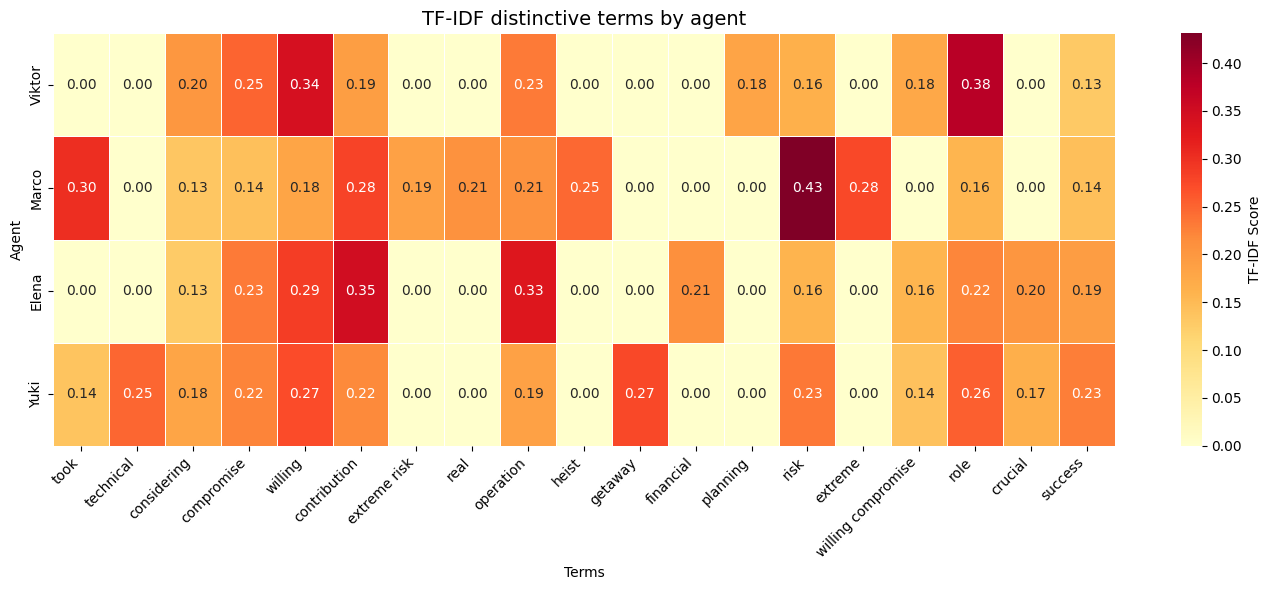

Top 5 distinctive terms per agent


,Agent,Top Distinctive Terms,Avg TF-IDF
0,Viktor,"role, willing, compromise, operation, considering",0.281
1,Marco,"risk, took, contribution, extreme, heist",0.307
2,Elena,"contribution, operation, willing, compromise, ...",0.284
3,Yuki,"getaway, willing, role, technical, risk",0.257


In [82]:
if len(turns_df) > 0 and tfidf_signatures:
    all_terms = set()
    for sig_df in tfidf_signatures.values():
        all_terms.update(sig_df["term"].head(8).tolist())
    
    heatmap_data = []
    for agent in tfidf_signatures.keys():
        sig_df = tfidf_signatures[agent].set_index("term")
        row = {term: sig_df.loc[term, "tfidf_score"] if term in sig_df.index else 0 
               for term in all_terms}
        row["agent"] = agent
        heatmap_data.append(row)
    
    heatmap_df = pd.DataFrame(heatmap_data).set_index("agent")
    
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap=COLOR_PALETTE['heatmap_seq'], ax=ax, 
                linewidths=0.5, cbar_kws={"label": "TF-IDF Score"})
    ax.set_title("TF-IDF distinctive terms by agent", fontsize=14)
    ax.set_xlabel("Terms")
    ax.set_ylabel("Agent")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    save_figure(fig, "heist_tfidf_distinctive_terms_heatmap")
    
    print("Top 5 distinctive terms per agent")
    summary_rows = []
    for agent, sig_df in tfidf_signatures.items():
        top_terms = ", ".join(sig_df["term"].head(5).tolist())
        avg_score = sig_df["tfidf_score"].head(5).mean()
        summary_rows.append({"Agent": agent, "Top Distinctive Terms": top_terms, "Avg TF-IDF": round(avg_score, 3)})
    
    display(pd.DataFrame(summary_rows))

### Cosine Similarity

Word embeddings transform text into dense vectors in semantic space. **Cosine similarity** measures alignment:
- **1.0** = identical meaning
- **0.0** = orthogonal (unrelated)
- **-1.0** = opposite meaning

In [83]:
def compute_semantic_convergence(df: pd.DataFrame, embedding_model) -> pd.DataFrame:
    results = []
    for (run_id, round_num), group in df.groupby(["run_id", "round"]):
        if len(group) < 2:
            continue

        agent_messages = {}
        for _, row in group.iterrows():
            agent = row["agent"]
            content = row["content"]
            if agent and content and len(content.strip()) > 10:
                agent_messages[agent] = content

        if len(agent_messages) < 2:
            continue
        
        agents = list(agent_messages.keys())
        texts = [agent_messages[a] for a in agents]
        
        try:
            embeddings = embedding_model.encode(texts)
        except Exception as e:
            continue
        
        sim_matrix = cosine_similarity(embeddings)
        n = len(agents)

        if n > 1:
            avg_sim = (sim_matrix.sum() - n) / (n * (n - 1))
        else:
            avg_sim = 1.0
        
        agreed = group["agreed"].iloc[0]
        results.append({
            "run_id": run_id,
            "round": round_num,
            "n_agents": n,
            "avg_similarity": avg_sim,
            "agreed": agreed
        })
    
    return pd.DataFrame(results)

if len(turns_df) > 0:
    convergence_df = compute_semantic_convergence(turns_df, embedding_model) # type: ignore
    
    if len(convergence_df) > 0:
        display(convergence_df.head()) 
else:
    convergence_df = pd.DataFrame()

,run_id,round,n_agents,avg_similarity,agreed
0,run_001,1,4,0.664287,True
1,run_001,2,4,0.647105,True
2,run_001,3,4,0.555853,True
3,run_001,4,4,0.651467,True
4,run_002,1,4,0.535621,True


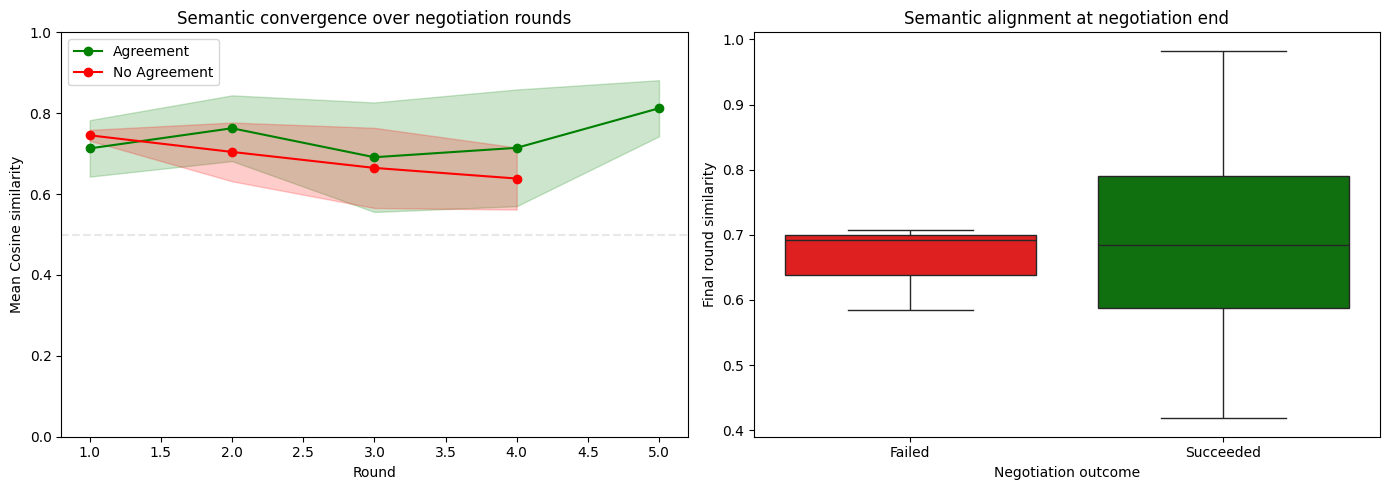

Convergence analysis:

Successful negotiations:
  Early rounds similarity: 0.738
  Late rounds similarity: 0.710
  Delta: -0.028

Failed negotiations:
  Early rounds similarity: 0.725
  Late rounds similarity: 0.657
  Delta: -0.068


In [84]:
if len(convergence_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for agreed, label, color in [(True, "Agreement", COLOR_PALETTE['agreement']), (False, "No Agreement", COLOR_PALETTE['disagreement'])]:
        subset = convergence_df[convergence_df["agreed"] == agreed]
        if len(subset) > 0:
            by_round = subset.groupby("round")["avg_similarity"].agg(["mean", "std"]).reset_index()
            axes[0].plot(by_round["round"], by_round["mean"], marker='o', label=label, color=color)
            axes[0].fill_between(by_round["round"], 
                                  by_round["mean"] - by_round["std"], 
                                  by_round["mean"] + by_round["std"], 
                                  alpha=0.2, color=color)
    
    axes[0].set_xlabel("Round")
    axes[0].set_ylabel("Mean Cosine similarity")
    axes[0].set_title("Semantic convergence over negotiation rounds")
    axes[0].legend()
    axes[0].set_ylim(0, 1)
    axes[0].axhline(y=0.5, color=COLOR_PALETTE['baseline'], linestyle='--', alpha=0.5, label='Baseline')
    
    final_rounds = convergence_df.groupby("run_id").apply(lambda x: x[x["round"] == x["round"].max()]).reset_index(drop=True)
    
    if len(final_rounds) > 0:
        sns.boxplot(data=final_rounds, x="agreed", y="avg_similarity", ax=axes[1], palette=get_outcome_colors())
        axes[1].set_xticklabels(["Failed", "Succeeded"])
        axes[1].set_xlabel("Negotiation outcome")
        axes[1].set_ylabel("Final round similarity")
        axes[1].set_title("Semantic alignment at negotiation end")       

    plt.tight_layout()
    plt.show()
    save_figure(fig, "heist_semantic_convergence_analysis")

    print("Convergence analysis:")
    for agreed in [True, False]:
        subset = convergence_df[convergence_df["agreed"] == agreed]
        if len(subset) > 0:
            early = subset[subset["round"] <= 2]["avg_similarity"].mean()
            late = subset[subset["round"] >= subset["round"].quantile(0.75)]["avg_similarity"].mean()
            delta = late - early
            label = "Successful" if agreed else "Failed"
            print(f"\n{label} negotiations:")
            print(f"  Early rounds similarity: {early:.3f}")
            print(f"  Late rounds similarity: {late:.3f}")
            print(f"  Delta: {delta:+.3f}")

### Sentiment Analysis (VADER)

VADER (Valence Aware Dictionary for sEntiment Reasoning) assigns sentiment scores:
- **compound**: Overall sentiment (-1 to +1)
- **pos/neg/neu**: Proportion of positive/negative/neutral tokens

In [85]:
def compute_sentiment(df: pd.DataFrame, analyzer) -> pd.DataFrame:
    sentiments = []
    
    for _, row in df.iterrows():
        content = row.get("content", "")
        if not content or len(content.strip()) < 5:
            sentiments.append({"compound": np.nan, "pos": np.nan, "neg": np.nan, "neu": np.nan})
            continue
        
        try:
            scores = analyzer.polarity_scores(content)
            sentiments.append(scores)
        except:
            sentiments.append({"compound": np.nan, "pos": np.nan, "neg": np.nan, "neu": np.nan})
    
    sentiment_df = pd.DataFrame(sentiments)
    return pd.concat([df.reset_index(drop=True), sentiment_df], axis=1)


if len(turns_df) > 0:
    turns_with_sentiment = compute_sentiment(turns_df, sentiment_analyzer)
    display(turns_with_sentiment[["agent", "round", "compound", "pos", "neg", "neu", "content"]].head())
else:
    turns_with_sentiment = turns_df.copy()
    turns_with_sentiment["compound"] = np.nan

,agent,round,compound,pos,neg,neu,content
0,Viktor,1,0.6808,0.165,0.045,0.791,"PROPOSAL: Viktor: 30.0%, Marco: 20.0%, Elena: ..."
1,Marco,1,0.4164,0.120,0.064,0.816,"[PROPOSAL]: Marco: 35.0%, Viktor: 25.0%, Elena..."
2,Elena,1,0.3818,1.000,0.000,0.000,[ACCEPT]
3,Yuki,1,0.8934,0.219,0.033,0.747,"[PROPOSAL]: Viktor: 25.0%, Marco: 30.0%, Elena..."
4,Viktor,2,0.5606,0.125,0.039,0.836,"[PROPOSAL]: Viktor: 28.0%, Marco: 30.0%, Elena..."


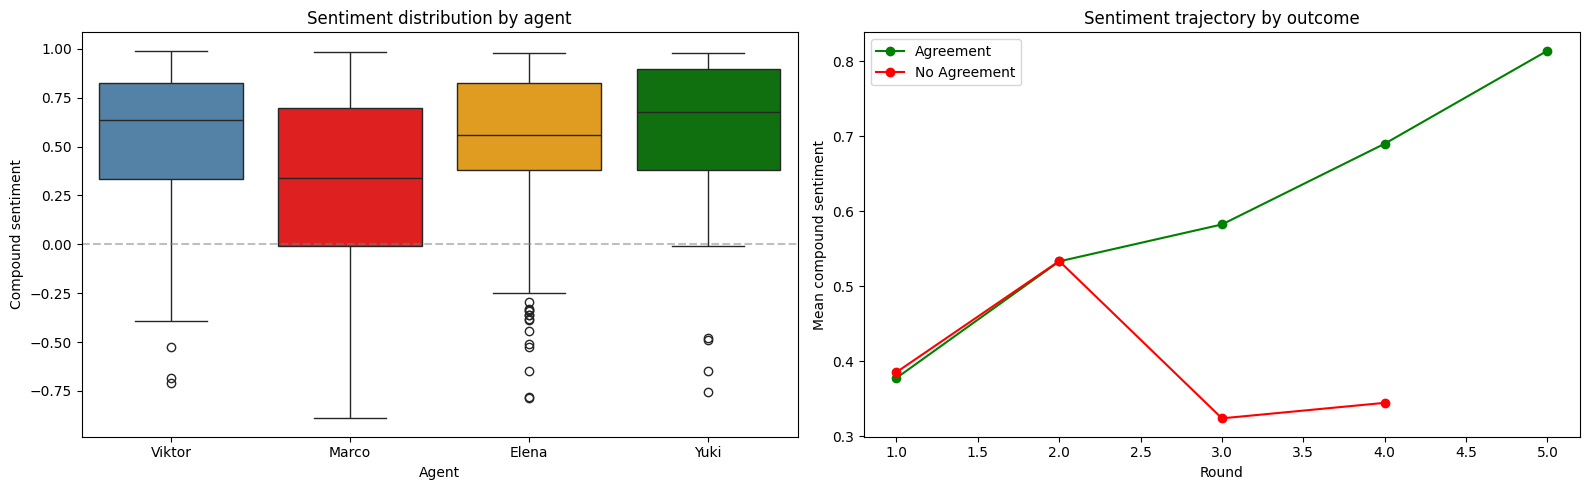

In [86]:
if "compound" in turns_with_sentiment.columns:
    valid_sentiment = turns_with_sentiment[turns_with_sentiment["compound"].notna()]
    
    if len(valid_sentiment) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        
        agent_order = ["Viktor", "Marco", "Elena", "Yuki"]
        sns.boxplot(data=valid_sentiment, x="agent", y="compound", ax=axes[0], 
                   order=agent_order, palette=get_agent_colors(agent_order))
        axes[0].axhline(y=0, color=COLOR_PALETTE['neutral'], linestyle="--", alpha=0.5)
        axes[0].set_title("Sentiment distribution by agent")
        axes[0].set_ylabel("Compound sentiment")
        axes[0].set_xlabel("Agent")
        
        for agreed, label, color in [(True, "Agreement", COLOR_PALETTE['agreement']), (False, "No Agreement", COLOR_PALETTE['disagreement'])]:
            subset = valid_sentiment[valid_sentiment["agreed"] == agreed]
            if len(subset) > 0:
                by_round = subset.groupby("round")["compound"].mean()
                axes[1].plot(by_round.index, by_round.values, marker='o', label=label, color=color)

        axes[1].set_xlabel("Round")
        axes[1].set_ylabel("Mean compound sentiment")
        axes[1].set_title("Sentiment trajectory by outcome")
        axes[1].legend()
        
        plt.tight_layout()
        plt.show()

        save_figure(fig, "heist_sentiment_analysis")

In [87]:
if "compound" in turns_with_sentiment.columns:
    valid_sentiment = turns_with_sentiment[turns_with_sentiment["compound"].notna()]
    
    if len(valid_sentiment) > 0:
        print("Sentiment statistics by agent:")
        
        sentiment_stats = valid_sentiment.groupby("agent")["compound"].agg([
            ("Mean", "mean"),
            ("SD", "std"),
            ("Min", "min"),
            ("Max", "max"),
            ("N", "count")
        ]).round(3)
        
        display(sentiment_stats)

Sentiment statistics by agent:


,Mean,SD,Min,Max,N
agent,,,,,
Elena,0.526,0.339,-0.788,0.978,573
Marco,0.271,0.472,-0.890,0.985,629
Viktor,0.557,0.322,-0.710,0.990,734
Yuki,0.592,0.329,-0.755,0.978,512


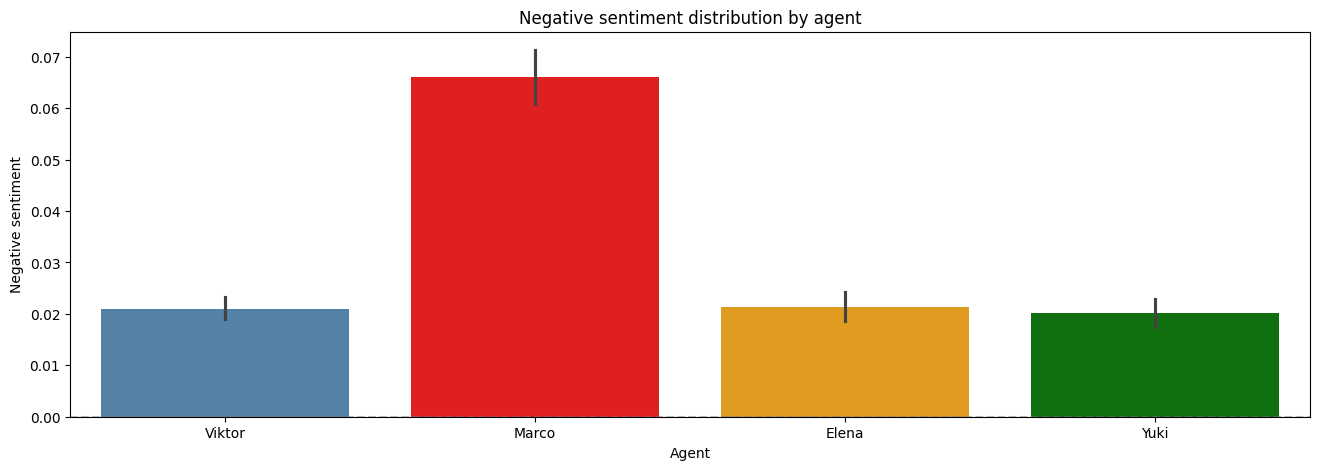

In [88]:
fig, ax = plt.subplots(figsize=(16, 5))
agent_order = ["Viktor", "Marco", "Elena", "Yuki"]
sns.barplot(data=valid_sentiment, x="agent", y="neg", order=agent_order, 
           palette=get_agent_colors(agent_order), ax=ax)
ax.axhline(y=0, color=COLOR_PALETTE['neutral'], linestyle="--", alpha=0.5)
ax.set_title("Negative sentiment distribution by agent")
ax.set_ylabel("Negative sentiment")
ax.set_xlabel("Agent")

plt.show()
save_figure(fig, "heist_negative_sentiment_analysis")

### Type-Token Ratio

**Type-Token Ratio (TTR)** = Unique Words / Total Words

- **High TTR** (1): Rich, varied vocabulary (complex discourse)
- **Low TTR** (0): Repetitive, limited vocabulary (simple discourse)

In [89]:
def compute_ttr(text: str) -> float:
    words = re.findall(r'\b[a-zA-Z]+\b', text.lower())
    if len(words) == 0:
        return np.nan
    unique_words = set(words)
    return len(unique_words) / len(words)


def compute_msttr(text: str, segment_size: int = 50) -> float:
    words = re.findall(r'\b[a-zA-Z]+\b', text.lower())
    if len(words) < segment_size:
        return compute_ttr(text)
    
    ttrs = []
    for i in range(0, len(words) - segment_size + 1, segment_size):
        segment = words[i:i + segment_size]
        ttrs.append(len(set(segment)) / len(segment))
    
    return np.mean(ttrs) if ttrs else np.nan


def compute_lexical_metrics(df: pd.DataFrame) -> pd.DataFrame:
    results = []
    
    for agent in df["agent"].unique():
        if not agent:
            continue
        
        agent_data = df[df["agent"] == agent]
        all_text = " ".join(agent_data["content"].dropna().tolist())
        words = re.findall(r'\b[a-zA-Z]+\b', all_text.lower())
        total_words = len(words)
        unique_words = len(set(words))
        ttr = unique_words / total_words if total_words > 0 else np.nan
        msttr = compute_msttr(all_text, segment_size=50)
        avg_word_length = np.mean([len(w) for w in words]) if words else 0
        n_messages = len(agent_data)
        
        results.append({
            "Agent": agent,
            "Total Words": total_words,
            "Unique Words": unique_words,
            "TTR": round(ttr, 3),
            "MSTTR": round(msttr, 3) if not np.isnan(msttr) else np.nan,
            "Avg Word Length": round(avg_word_length, 2),
            "N Messages": n_messages
        })
    
    return pd.DataFrame(results)


if len(turns_df) > 0:
    lexical_df = compute_lexical_metrics(turns_df)
    display(lexical_df)
else:
    lexical_df = pd.DataFrame()

,Agent,Total Words,Unique Words,TTR,MSTTR,Avg Word Length,N Messages
0,Viktor,30291,766,0.025,0.770,4.94,734
1,Marco,24725,831,0.034,0.778,4.64,629
2,Elena,19791,753,0.038,0.792,4.91,573
3,Yuki,15912,653,0.041,0.790,4.88,512


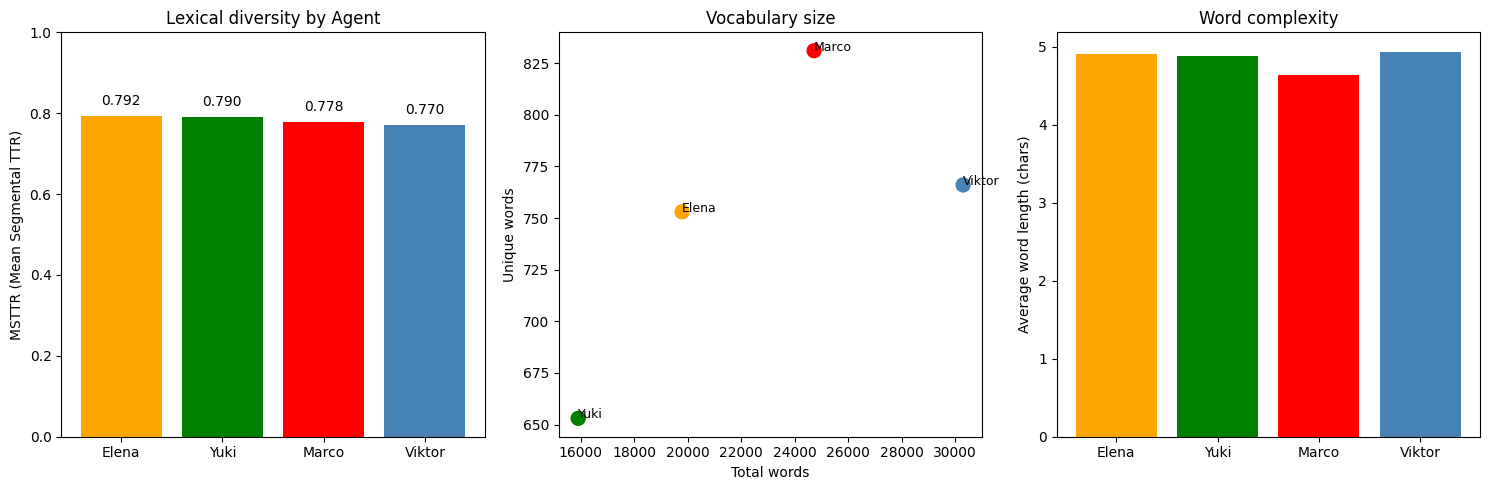

In [90]:
if len(lexical_df) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    lexical_sorted = lexical_df.sort_values("MSTTR", ascending=False)
    
    agent_colors = get_agent_colors(list(lexical_sorted["Agent"]))
    bars = axes[0].bar(lexical_sorted["Agent"], lexical_sorted["MSTTR"], color=agent_colors)
    axes[0].set_ylabel("MSTTR (Mean Segmental TTR)")
    axes[0].set_title("Lexical diversity by Agent")
    axes[0].set_ylim(0, 1)
    
    for bar, val in zip(bars, lexical_sorted["MSTTR"]):
        if not np.isnan(val):
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                        f"{val:.3f}", ha='center', va='bottom', fontsize=10)
    
    agent_to_idx = {agent: i for i, agent in enumerate(['Viktor', 'Marco', 'Elena', 'Yuki'])}
    colors = [agent_to_idx.get(row["Agent"], 0) for _, row in lexical_df.iterrows()]
    scatter = axes[1].scatter(lexical_df["Total Words"], lexical_df["Unique Words"], 
                             s=100, c=colors, cmap=plt.cm.colors.ListedColormap(get_agent_colors()))
    for _, row in lexical_df.iterrows():
        axes[1].annotate(row["Agent"], (row["Total Words"], row["Unique Words"]), 
                        fontsize=9, ha='left')
    axes[1].set_xlabel("Total words")
    axes[1].set_ylabel("Unique words")
    axes[1].set_title("Vocabulary size")
    
    agent_colors = get_agent_colors(list(lexical_sorted["Agent"]))
    bars = axes[2].bar(lexical_sorted["Agent"], lexical_sorted["Avg Word Length"], 
                       color=agent_colors)
    axes[2].set_ylabel("Average word length (chars)")
    axes[2].set_title("Word complexity")

    save_figure(fig, "lexical_diversity_analysis")

    plt.tight_layout()    
    plt.show()